# **사전준비**

In [ ]:
!pip install torch torchvision
!pip install catalyst==20.12
!pip install segmentation-models-pytorch

from typing import Callable, List, Tuple
import os
import torch
import catalyst
from catalyst import utils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 490 kB 5.3 MB/s 
     |████████████████████████████████| 125 kB 18.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 4.2 MB/s 
     |████████████████████████████████| 58 kB 7.1 MB/s 
     |████████████████████████████████| 376 kB 51.6 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=c8d41c6236104603cb539aba88b46ace18b6057430e271c6faf954006ebaab8f
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=8af4f36f5a7430380843a9b8736c

# **데이터 불러오기**


In [ ]:
import requests
import zipfile

DATA_URL = 'https://drive.google.com/u/0/uc?id=1ltBLsOPMPvZ7BV_fIF6HSjIqWr8FDCI5&export=download'
DATA_PATH = os.path.join('.', 'data')
FILE_NAME = os.path.join(DATA_PATH, 'V_data.zip')

if not os.path.isfile(FILE_NAME):
  print("Downloading the data...")
  os.makedirs('data', exist_ok=True)
  with requests.get(DATA_URL) as req:
    with open(FILE_NAME, 'wb') as f:
      f.write(req.content)
  if 200 <= req.status_code < 300:
    print("Download complete!")
  else:
    print("Download failed!")
else:
  print(FILE_NAME, "already exists, skipping download...")

with zipfile.ZipFile(FILE_NAME, 'r') as zip_ref:
  print("Unzipping...")
  zip_ref.extractall('data')

DATA_PATH = os.path.join(DATA_PATH, 'V_data')

Download complete!
Unzipping...


# **결과값 저장할 폴더 생성**

In [ ]:
#데이터 저장할 폴더 생성
import os.path
dir_path = "/content"
dir_name = "Res"
if os.path.isdir("/content/Res"):
  print("File is already exist")
else:
  os.mkdir(dir_path + "/" + dir_name + "/")

# **데이터 예시**

In [ ]:
from pathlib import Path

ROOT = Path("data/V_data/Test")

train_image_path = ROOT / "Images"
train_mask_path = ROOT / "Masks"

In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread as gif_imread


def show_examples(name: str, image: np.ndarray, mask: np.ndarray):
    plt.figure(figsize=(10, 14))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f"Image: {name}")

    plt.subplot(1, 2, 2)
    plt.imshow(mask)
    plt.title(f"Mask: {name}")


def show(index: int, images: List[Path], masks: List[Path]):
    image_path = images[index]
    name = image_path.name

    image = utils.imread(image_path)
    mask = utils.imread(masks[index])

    show_examples(name, image, mask)


def show_random(images: List[Path], masks: List[Path]):
    length = len(images)
    index = random.randint(0, length - 1)
    show(index, images, masks)

ALL_IMAGES = sorted(train_image_path.glob("*.jpg"))
ALL_MASKS = sorted(train_mask_path.glob("*.png"))

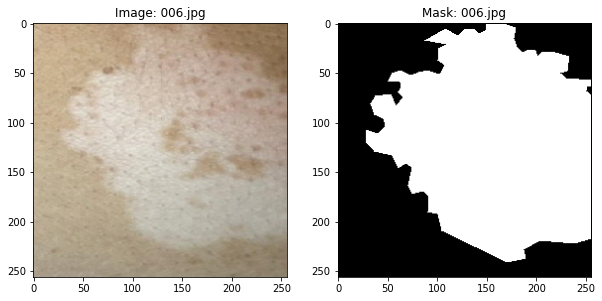

In [ ]:
show_random(ALL_IMAGES, ALL_MASKS)

# **Pytorch 데이터로더**

In [ ]:
from typing import Any, Callable, Optional
from PIL import Image
from torchvision.datasets.vision import VisionDataset



class SegmentationDataset(VisionDataset):

    def __init__(self,
                 root: str,
                 image_folder: str,
                 mask_folder: str,
                 transforms: Optional[Callable] = None,
                 subset: str = None,
                 ) -> None:

        super().__init__(root, transforms)
        image_folder_path = Path(self.root) / image_folder
        mask_folder_path = Path(self.root) / mask_folder
        if not image_folder_path.exists():
            raise OSError(f"{image_folder_path} does not exist.")
        if not mask_folder_path.exists():
            raise OSError(f"{mask_folder_path} does not exist.")

        self.image_names = sorted(image_folder_path.glob("*"))
        self.mask_names = sorted(mask_folder_path.glob("*"))



    def __len__(self) -> int:
        return len(self.image_names)

    def __getitem__(self, index: int) -> Any:
        image_path = self.image_names[index]
        mask_path = self.mask_names[index]
        data_transforms = transforms.Compose([transforms.ToTensor()])
        
        with open(image_path, "rb") as image_file, open(mask_path,
                                                        "rb") as mask_file:
            image = Image.open(image_file)
            image = image.convert("RGB")

            mask = Image.open(mask_file)
            mask = mask.convert("L")

        if self.root == Path('data/V_data/Train'):
            aug_image,aug_mask = self.transforms(image,mask)
            sample = {"image": aug_image, "mask": aug_mask}
        
        
        if self.root == Path('data/V_data/Test'):
            image = data_transforms(image)
            mask = data_transforms(mask)
            sample = {"image": image, "mask": mask}

        return sample

In [ ]:
from torch.utils.data import DataLoader
from torchvision import transforms


def get_dataloader(data_dir: str,
                              image_folder: str = 'Images',
                              mask_folder: str = 'Masks',
                              batch_size: int = 5):

    data_transforms =  transform

    image_datasets = {
        x: SegmentationDataset(root=Path(data_dir) / x,
                               transforms=data_transforms,
                               image_folder=image_folder,
                               mask_folder=mask_folder,)
        for x in ['Train', 'Test']
    }
    dataloaders = {
        x: DataLoader(image_datasets[x],
                      batch_size=batch_size,
                      shuffle=True,
                      num_workers=1)
        for x in ['Train', 'Test']
    }
    return dataloaders

# **데이터 증강**

In [ ]:
import torchvision.transforms.functional as TF
def transform(image, mask):
    # Resize 256,256 -> 312,312
    resize = transforms.Resize(size=(312, 312))
    image = resize(image)
    mask = resize(mask)

    # Random crop 312,312 -> 256,256
    i, j, h, w = transforms.RandomCrop.get_params(
            image, output_size=(256, 256))
    image = TF.crop(image, i, j, h, w)
    mask = TF.crop(mask, i, j, h, w)

    # Random horizontal flipping
    if random.random() > 0.5:
        image = TF.hflip(image)
        mask = TF.hflip(mask)

    # Random vertical flipping
    if random.random() > 0.5:
        image = TF.vflip(image)
        mask = TF.vflip(mask)

    # Random adjust brightness
    BR = np.random.uniform(0.7,1.3)
    if random.random() > 0.5:
        image = TF.adjust_brightness(image, BR)
        mask = TF.adjust_brightness(mask, BR)

    # Transform to tensor
    image = TF.to_tensor(image)
    mask = TF.to_tensor(mask)
    return image, mask

In [ ]:
from pathlib import Path
loaders = get_dataloader('data/V_data')

# **모델 다운로드**

In [ ]:
# From segmentation_models_pytorch -> Unet, Deeplab, ...
# outputs['out'] -> outputs
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name="resnet50",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
)

In [ ]:
# From torchvision.models -> Fcn, Deeplab, ...
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
from torchvision.models.segmentation.deeplabv3 import FCNHead
from torchvision import models
model = models.segmentation.deeplabv3_resnet101(pretrained=True,
                                                    progress=True)
model.classifier = DeepLabHead(2048, 1)

# **학습**

In [ ]:
import copy
import csv
from tqdm import tqdm


def train_model(model, criterion, dataloaders, optimizer, metrics, bpath,
                num_epochs):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    fieldnames = ['epoch', 'Train_loss', 'Test_loss'] + \
        [f'Train_{m}' for m in metrics.keys()] + \
        [f'Test_{m}' for m in metrics.keys()]
    with open(os.path.join(bpath, 'log.csv'), 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

    for epoch in range(1, num_epochs + 1):
        print('=' * 50)
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 50)

        batchsummary = {a: [0] for a in fieldnames}

        for phase in ['Train', 'Test']:
            if phase == 'Train':
                model.train()  
            else:
                model.eval()  

            for sample in tqdm(iter(dataloaders[phase])):
                inputs = sample['image'].to(device)
                masks = sample['mask'].to(device)

                optimizer.zero_grad() # gradients 초기화

                with torch.set_grad_enabled(phase == 'Train'):
                    outputs = model(inputs)
                    loss = criterion(outputs['out'], masks)
                    y_pred = outputs['out'].data.cpu().numpy().ravel()
                    y_true = masks.data.cpu().numpy().ravel()
                    for name, metric in metrics.items():
                            batchsummary[f'{phase}_{name}'].append(
                                metric(y_true > 0, y_pred > 0.5))

                    if phase == 'Train':
                        loss.backward()
                        optimizer.step()
            batchsummary['epoch'] = epoch
            epoch_loss = loss
            batchsummary[f'{phase}_loss'] = epoch_loss.item()
        for field in fieldnames[3:]:
            batchsummary[field] = np.mean(batchsummary[field])
        print()
        print(batchsummary)
        with open(os.path.join(bpath, 'log.csv'), 'a', newline='') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            writer.writerow(batchsummary)

            if phase == 'Test' and loss < best_loss:
                best_loss = loss
                best_model_wts = copy.deepcopy(model.state_dict())

    print('Lowest Loss: {:4f}'.format(best_loss))


    model.load_state_dict(best_model_wts)
    return model

In [ ]:
from sklearn.metrics import f1_score

criterion = torch.nn.MSELoss() # Loss Function = MSE
optimizer = torch.optim.Adam(model.parameters(), lr=4e-5) # Optimizer = Adam
metrics = {'f1_score': f1_score} # Metric = f1 score
bpath = Path('/content/Res') # 결과값 저장경로
num_epochs = 20


train_model(model, criterion, loaders, optimizer, metrics, bpath, num_epochs)

# **학습 결과 시각화**

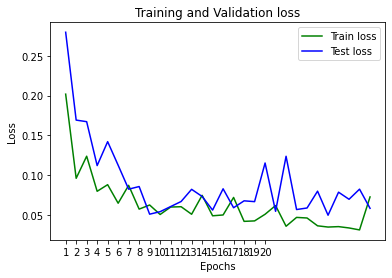

In [ ]:
import cv2
import pandas as pd

df = pd.read_csv('Res/log.csv')
max = df.epoch.max()

plt.plot(df.epoch, df.Train_loss, 'g', label='Train loss')
plt.plot(df.epoch, df.Test_loss, 'b', label='Test loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(1,max+1))
plt.legend()
plt.show()

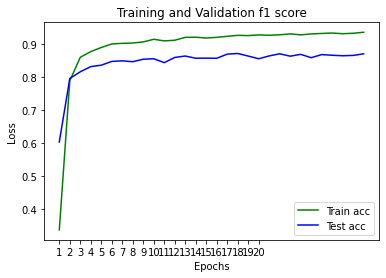

In [ ]:
plt.plot(df.epoch, df.Train_f1_score, 'g', label='Train acc')
plt.plot(df.epoch, df.Test_f1_score, 'b', label='Test acc')
plt.title('Training and Validation f1 score')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(1,max+1))
plt.legend()
plt.show()

# **새로 학습한 모델을 통한 예측**

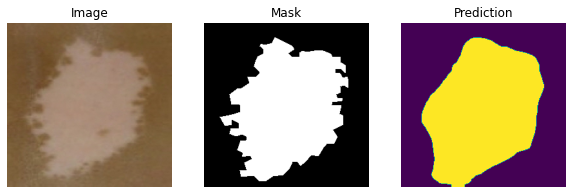

In [ ]:
filename = "data/V_data/Train/Images/287.jpg"
M_filename = "data/V_data/Train/Masks/287.png"
img = Image.open(filename)
mask = Image.open(M_filename)
img = np.array(img).transpose(2,0,1)
img = np.reshape(img,(1,3,256,256))

with torch.no_grad():
    a = model(torch.from_numpy(img).type(torch.cuda.FloatTensor)/255) #Probability Map 생성



plt.figure(figsize=(10,10));
plt.subplot(131);
plt.imshow(img[0,...].transpose(1,2,0));
plt.title('Image')
plt.axis('off');
plt.subplot(132);
plt.imshow(mask);
plt.title('Mask')
plt.axis('off');
plt.subplot(133);
plt.imshow(a['out'].cpu().detach().numpy()[0][0]>0.5); #Probability Map에서 0.3을 Threshold로 잡기
plt.title('Prediction')
plt.axis('off');

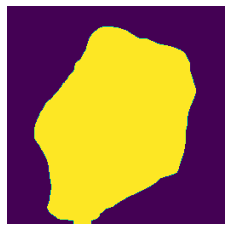

In [ ]:
plt.imshow(a['out'].cpu().detach().numpy()[0][0]>0.3);
plt.axis('off');
plt.savefig('./SegmentationOutput.png',bbox_inches='tight',pad_inches = 0)

# **병변심각도 측정**

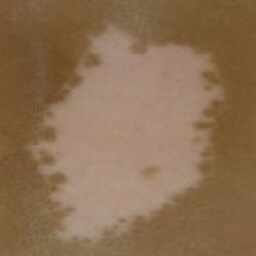

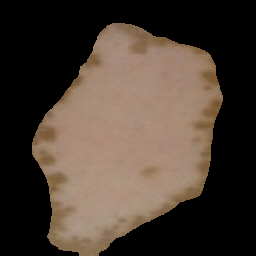

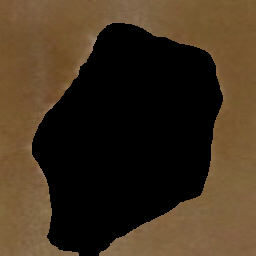

In [ ]:
from google.colab.patches import cv2_imshow

gray_img = cv2.imread("SegmentationOutput.png",cv2.IMREAD_GRAYSCALE)
mask_img = cv2.resize(gray_img,(256,256))
ret,mask_img = cv2.threshold(mask_img, 127, 255, cv2.THRESH_BINARY) # 마스크 이미지 생성
ret,reverse_mask_img = cv2.threshold(mask_img, 127, 255, cv2.THRESH_BINARY_INV) # 마스크 뒤집은 이미지 생성 

img = Image.open(filename)
numpy_img = np.array(img)
img = cv2.cvtColor(numpy_img, cv2.COLOR_RGB2BGR)
img_1 = cv2.cvtColor(numpy_img, cv2.COLOR_RGB2BGR)
img_2 = cv2.cvtColor(numpy_img, cv2.COLOR_RGB2BGR)


img_1 = cv2.bitwise_and(img,img,mask = mask_img)
img_2 = cv2.bitwise_and(img,img,mask = reverse_mask_img)

cv2_imshow(img)
cv2_imshow(img_1)
cv2_imshow(img_2)

In [ ]:
# Mask를 통해 계산한 병변영역과 비병변영역의 RGB평균값 비교
a = cv2.mean(img,mask=mask_img)
b = cv2.mean(img,mask=reverse_mask_img)
a_mean = np.sum(a) / 3
b_mean = np.sum(b) / 3 
print(a_mean,b_mean)

133.9983849171034 90.44883560151908
